In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA 
import pyLDAvis.sklearn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

pd.set_option("display.max_rows", 9999)
pd.set_option("display.max_columns", 9999)
plt.style.use('seaborn')

# Features Engineering

In [2]:
tweets = pd.read_csv('../datasets/cleaned_tweets.csv')

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22394 entries, 0 to 22393
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          22394 non-null  object 
 1   text            22394 non-null  object 
 2   created_at      22394 non-null  object 
 3   retweet_count   22394 non-null  float64
 4   favorite_count  22394 non-null  float64
 5   is_retweet      22394 non-null  float64
 6   clean_text      22394 non-null  object 
 7   year            22394 non-null  int64  
 8   month           22394 non-null  int64  
 9   day             22394 non-null  int64  
 10  year_month      22394 non-null  object 
 11  day_of_week     22394 non-null  int64  
 12  hour_of_day     22394 non-null  int64  
 13  handle          11683 non-null  object 
 14  word_count      22394 non-null  int64  
 15  trade_date      22394 non-null  object 
 16  prev_change     22394 non-null  float64
 17  change_pc       22394 non-null 

We observed that some of President Trump tweets have very low word count which could result as noise in the modelling hence we deicded to drop tweets than have less than 3 word counts. Also will we will be focusing on his tweets rather than retweets. Will drop all the retweets as well.

In [4]:
#drop word count < 3
tweets = tweets.drop(tweets[tweets['word_count'] <= 3].index)

In [5]:
#drop retweets
mask = tweets['is_retweet'] == 0
tweets = tweets.loc[mask, :]

In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19240 entries, 0 to 22393
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   source          19240 non-null  object 
 1   text            19240 non-null  object 
 2   created_at      19240 non-null  object 
 3   retweet_count   19240 non-null  float64
 4   favorite_count  19240 non-null  float64
 5   is_retweet      19240 non-null  float64
 6   clean_text      19240 non-null  object 
 7   year            19240 non-null  int64  
 8   month           19240 non-null  int64  
 9   day             19240 non-null  int64  
 10  year_month      19240 non-null  object 
 11  day_of_week     19240 non-null  int64  
 12  hour_of_day     19240 non-null  int64  
 13  handle          9266 non-null   object 
 14  word_count      19240 non-null  int64  
 15  trade_date      19240 non-null  object 
 16  prev_change     19240 non-null  float64
 17  change_pc       19240 non-null 

### Stopwords

In [7]:
my_additional_stop_words = {'rt', 'great', 'thank', 'just', 'president',
                            'want', 'trump', 'new', 'today', 'big', 'make',
                            'people', 'time' , 'democrat', 'democrats', 
                            'fake', 'news', 'america',
                            'american','time', 'like'}

### Topic model

In order to have a better understanding on the context of the tweets, we will be using a technique in NLP called Topic Modelling Latent Dirichlet allocation(LDA) to assign a topic to each tweet. Here we will be looking only Trade/Economy related tweets.

In [8]:
#initialize spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
nlp.Defaults.stop_words |= my_additional_stop_words

In [10]:
#create a function to lemmatize
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False) and (token.is_digit == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas

In [11]:
tweets['lemmas_token'] = tweets['clean_text'].apply(lambda t: get_lemmas(t))

In [12]:
tweets['lemmas_text'] = tweets['lemmas_token'].apply(lambda w : " ".join(w))

In [13]:
tweets.to_csv('../datasets/lemma_tweets.csv', index=False)

In [14]:
tweets = pd.read_csv('../datasets/lemma_tweets.csv')

In [15]:
tweets.dropna(inplace=True, subset=['lemmas_text'])

In [16]:
tweets.reset_index(inplace=True)

In [17]:
#initialize the count vectorizer
cvec = CountVectorizer()

In [18]:
text_data = cvec.fit_transform(tweets['lemmas_text'])


In [19]:
text_data.shape

(19150, 13299)

In [52]:
# Create and fit the LDA model
lda = LDA(n_components=6, random_state=42, evaluate_every=0, max_iter=100, topic_word_prior=0.8)

In [53]:
%%time
lda.fit(text_data)

CPU times: user 5min 16s, sys: 1.29 s, total: 5min 17s
Wall time: 5min 21s


LatentDirichletAllocation(evaluate_every=0, max_iter=100, n_components=6,
                          random_state=42, topic_word_prior=0.8)

In [54]:
#create a function to print out the topics and the key words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    print()

In [55]:
#print out the topic and key words
print_top_words(lda, cvec.get_feature_names(), 50)

Topic #0: fbi russia report hunt election witch collusion mueller story campaign obama court hillary know book clinton justice comey medium bad look go state get crooked year russian investigation lie say don history dem happen hoax judge time general crime good political didn case fact phony supreme find write john ballot

Topic #1: country year border job china good state deal come work trade economy wall security united dollar world pay go get high billion number need tax strong cut record build help low way far mexico win administration drug don tariff korea take thing bad military market look well stop usa north

Topic #2: biden house joe medium say impeachment white go republican schiff pelosi get left dem bad radical nancy don know win party watch vote crazy call think senate sleepy adam good corrupt try look country run work thing poll doesn ukraine fact conference whistleblower want day way totally bernie police right

Topic #3: honor state day nation woman family national uni

In [56]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, text_data, cvec)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.052660 -0.155962       1        1  29.202008
2      0.111341  0.061854       2        1  19.965838
0      0.145251  0.043758       3        1  19.814741
3     -0.106090  0.014553       4        1  12.867535
5     -0.102688 -0.050072       5        1  11.351651
4     -0.100474  0.085870       6        1   6.798227, topic_info=                            Term         Freq        Total Category  logprob  \
12797                       vote   683.000000   683.000000  Default  30.0000   
6401                         job   955.000000   955.000000  Default  29.0000   
1220                       biden   548.000000   548.000000  Default  28.0000   
1402                      border   832.000000   832.000000  Default  27.0000   
6408                         joe   462.000000   462.000000  Default  26.0000   
5603                       house   589.000000   589.000000  Default  25.0000   
1980                       china   582.000000   582.000000  Default  24.0000   
11359                     strong   494.000000   494.000000  Default  23.0000   
5541                       honor   300.000000   300.000000  Default  22.0000   
11970                      total   365.000000   365.000000  Default  21.0000   
3891                 endorsement   258.000000   258.000000  Default  20.0000   
7091                        love   365.000000   365.000000  Default  19.0000   
7444                      medium   567.000000   567.000000  Default  18.0000   
7164                        maga   255.000000   255.000000  Default  17.0000   
2925                        deal   513.000000   513.000000  Default  16.0000   
4346                         fbi   334.000000   334.000000  Default  15.0000   
5831                 impeachment   405.000000   405.000000  Default  14.0000   
13070                        win   786.000000   786.000000  Default  13.0000   
2604                 coronavirus   213.000000   213.000000  Default  12.0000   
5670                        hunt   312.000000   312.000000  Default  11.0000   
13101                      witch   306.000000   306.000000  Default  10.0000   
9902                  republican   716.000000   716.000000  Default   9.0000   
2338                    complete   255.000000   255.000000  Default   8.0000   
10257                     russia   385.000000   385.000000  Default   7.0000   
2217                   collusion   287.000000   287.000000  Default   6.0000   
13021                      white   302.000000   302.000000  Default   5.0000   
9884                      report   391.000000   391.000000  Default   4.0000   
7568                    military   442.000000   442.000000  Default   3.0000   
11210                      state  1175.000000  1175.000000  Default   2.0000   
7852                     mueller   282.000000   282.000000  Default   1.0000   
1980                       china   578.688858   582.392120   Topic1  -4.7105   
12001                      trade   372.974747   376.326543   Topic1  -5.1497   
11656                     tariff   201.676225   204.649024   Topic1  -5.7646   
7521                      mexico   222.215737   225.540902   Topic1  -5.6676   
6655                       korea   201.451964   204.624987   Topic1  -5.7657   
3617                        drug   204.459708   207.917255   Topic1  -5.7509   
7294                      market   188.863488   192.057463   Topic1  -5.8302   
6243                        iran   174.369357   177.795925   Topic1  -5.9101   
11289                      stock   149.605506   152.696111   Topic1  -6.0632   
3518                      dollar   301.847407   308.320027   Topic1  -5.3613   
11040                   southern   144.321342   147.641357   Topic1  -6.0992   
9209                       price   151.667891   155.183612   Topic1  -6.0495   
12338               unemployment   131.915551   135.082166   Topic1  -6.1891   
2925 

From the keys words of the topic model we conclude that President Trump tweets revolved around this 6 topics:

Topic 0: Trump/Russia collusion 

Topic 1: Trade/Economy

Topic 2: Impeachment

Topic 3: Others

Topic 4: Coronavirus

Topic 5: Election Campaign

In [57]:
lda_results = lda.transform(text_data)

In [58]:
#columns names
topic_names = [f"topic_{str(i)}" for i in range(lda.n_components)]

In [59]:
#add this topic scores to dataframe
tweets[topic_names] = pd.DataFrame(np.round(lda_results, 3))

In [60]:
#add column to show dominant topic
tweets['dominant_topic'] = np.argmax(tweets[topic_names].values, axis=1)

In [61]:
#give the topic a name instead of number for easier interpretation
tweets['dominant_topic'] = tweets['dominant_topic'].map({0: 'collusion',
                                                         1: 'trade',
                                                         2: 'impeachment',
                                                         3: 'others',
                                                         4: 'covid',
                                                         5: 'election'
})

Text(0.5, 1.0, 'Tweets Topics')

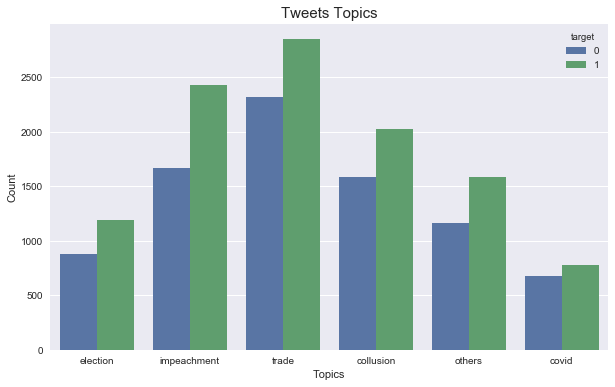

In [62]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=tweets, x='dominant_topic', hue='target', ax=ax)
ax.set_xlabel('Topics')
# ax.set_xticklabels(['Impeachment', 'Immigration', 'Election', 'Trade'], rotation=0)
ax.set_ylabel('Count')
ax.set_title('Tweets Topics', fontsize=15)

In [63]:
tweets['dominant_topic'].value_counts(normalize=True)

trade          0.269922
impeachment    0.213995
collusion      0.188407
others         0.143238
election       0.108407
covid          0.076031
Name: dominant_topic, dtype: float64

In [89]:
#filter out trade related tweets only
tweets_trade = tweets.loc[tweets['dominant_topic'] == 'trade'].copy()


In [94]:
tweets_trade.reset_index(drop=True, inplace=True)
tweets_trade.drop(columns='index', inplace=True)

Through topic modelling we able to categorize President Trump tweets into 6 topics. We will only be focusing on trade and economy related tweets. 

### Sentiment Analysis

Sentiment Analysis, is a sub-field of Natural Language Processing (NLP) that tries to identify and extract opinions within a given text. The aim of sentiment analysis is to gauge the attitude, sentiments, evaluations, attitudes and emotions of a speaker/writer based on the computational treatment of subjectivity in a text. I will be using VADER (Valence Aware Dictionary and sEntiment Reasoner) to analyze Presdient Trump tweets. Using VADER will tells about the Positivity and Negativity score and also tells us about how positive or negative a sentiment is.

In [96]:
#initialize the model
analyser = SentimentIntensityAnalyzer()

In [97]:
#create a function to print the scores
def sentiment_analyzer_scores(sentence):
    return analyser.polarity_scores(sentence)
    

In [98]:
print(tweets_trade['text'][1])
print(f"Score for raw text: {sentiment_analyzer_scores(tweets_trade['text'][1])}")

My highly regarded Executive Order protected 525,000 American jobs during the height of the Chinese Plague. Democrats want to have Open Borders!
Score for raw text: {'neg': 0.0, 'neu': 0.817, 'pos': 0.183, 'compound': 0.5411}


In [99]:
print(tweets_trade['clean_text'][1])
print(f"Score for clean text: {sentiment_analyzer_scores(tweets_trade['clean_text'][1])}")

my highly regarded executive order protected 525 000 american jobs during the height of the chinese plague democrats want to have open borders
Score for clean text: {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.4939}


In [100]:
print(tweets_trade['lemmas_text'][1])
print(f"Score for clean text: {sentiment_analyzer_scores(tweets_trade['lemmas_text'][1])}")

highly regard executive order protect job height chinese plague open border
Score for clean text: {'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.3818}


VADER analyses sentiments primarily based on certain key points such as punctuations, captialization, conjuction and emojis etc. Hence will be using the raw text for better accuracy.

In [101]:
tweets_trade['compound_score'] = tweets_trade['text'].apply(lambda s : sentiment_analyzer_scores(s)['compound'])

In [102]:
tweets_trade['neg_score'] = tweets_trade['text'].apply(lambda s : sentiment_analyzer_scores(s)['neg'])

In [103]:
tweets_trade['neu_score'] = tweets_trade['text'].apply(lambda s : sentiment_analyzer_scores(s)['neu'])

In [104]:
tweets_trade['pos_score'] = tweets_trade['text'].apply(lambda s : sentiment_analyzer_scores(s)['pos'])

In [105]:
print('Most Negative Tweet:')
print(tweets_trade[tweets_trade['compound_score'] == tweets_trade['compound_score'].min()]['text'].values)
print('')
print('Most Positive Tweet:')
print(tweets_trade[tweets_trade['compound_score'] == tweets_trade['compound_score'].max()]['text'].values)

Most Negative Tweet:
['It is outrageous that Poisonous Synthetic Heroin Fentanyl comes pouring into the U.S. Postal System from China. We can, and must, END THIS NOW! The Senate should pass the STOP ACT – and firmly STOP this poison from killing our children and destroying our country. No more delay!']

Most Positive Tweet:
['My supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. It is a beautiful thing to watch as we win elections and gather support from all over the country. As we get stronger, so does our country. Best numbers ever!']


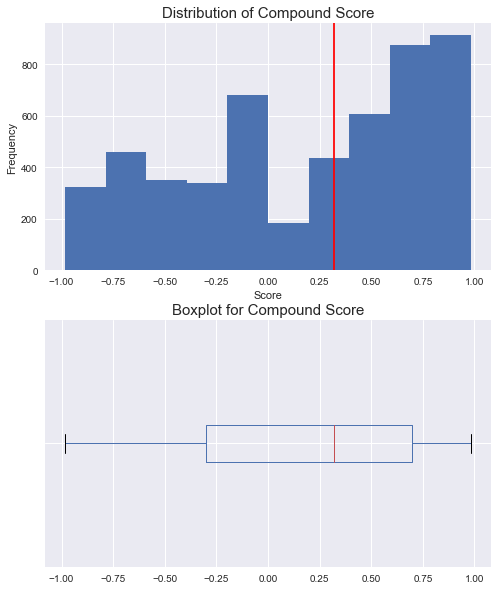

In [106]:
fig ,(ax1, ax2) = plt.subplots(nrows = 2, figsize=(8, 10))

tweets_trade['compound_score'].plot(kind='hist', ax=ax1, bins=10)
ax1.set_title('Distribution of Compound Score', fontsize=15)
ax1.set_xlabel('Score')
ax1.axvline(x=tweets_trade['compound_score'].median(), c='r')

tweets_trade['compound_score'].plot(kind='box', ax=ax2, vert=False)
ax2.set_title('Boxplot for Compound Score', fontsize=15)
ax2.set_yticklabels('');

In [107]:
tweets_trade[['compound_score']].describe().T

,count,mean,std,min,25%,50%,75%,max
compound_score,5169.0,0.186195,0.576857,-0.9825,-0.3004,0.3182,0.7003,0.9834


The distribution of the compound score seems to be slightly negatively skewed, with median greater than mean. The highest count are between -0.25 to 0. Most data are clustered between 0.5 to 1. And the lowest count is in the range between. 0 to 0.25. This gave us an indication that most of President Trump tweets have a positive sentiments score. Maybe too much during the start of covid?

In [108]:
tweets.head()

,index,source,text,created_at,retweet_count,favorite_count,clean_text,year,month,day,year_month,day_of_week,hour_of_day,handle,word_count,trade_date,prev_change,change_pc,target,char_count,lemmas_token,lemmas_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,dominant_topic
0,0,Twitter for iPhone,Mike Pence WON BIG!,2020-10-07 22:57:08-04:00,65210.0,418654.0,mike pence won big,2020,10,7,2020-10,2,22,NaN,4,2020-10-08,0.017407,0.008863,1,18,"['mike', 'penny', 'win']",mike penny win,0.042,0.042,0.042,0.042,0.042,0.791,election
1,1,Twitter for iPhone,"2010 to 2016 under Kamala Harris's watch as ""T...",2020-10-07 22:40:57-04:00,26438.0,70249.0,2010 to 2016 under kamala harris s watch as to...,2020,10,7,2020-10,2,22,NaN,11,2020-10-08,0.017407,0.008863,1,51,"['kamala', 'harris', 's', 'watch', 'cop']",kamala harris s watch cop,0.034,0.033,0.833,0.033,0.033,0.033,impeachment
2,2,Twitter for iPhone,Moderator cut off @VP Mike Pence while discuss...,2020-10-07 22:09:36-04:00,28864.0,73680.0,moderator cut off mike pence while discussing ...,2020,10,7,2020-10,2,22,@VP,28,2020-10-08,0.017407,0.008863,1,164,"['moderator', 'cut', 'mike', 'pence', 'discuss...",moderator cut mike pence discuss knight columb...,0.011,0.011,0.944,0.011,0.011,0.011,impeachment
3,3,Twitter for iPhone,"“Biden TAX PLAN would raise $4 TRILLION, more ...",2020-10-07 22:05:12-04:00,17752.0,51095.0,biden tax plan would raise 4 trillion more tha...,2020,10,7,2020-10,2,22,NaN,17,2020-10-08,0.017407,0.008863,1,90,"['biden', 'tax', 'plan', 'raise', 'trillion', ...",biden tax plan raise trillion twice hike propo...,0.130,0.671,0.149,0.017,0.017,0.017,trade
4,4,Twitter for iPhone,Joe Biden opposed taking out Osama bin Laden.....,2020-10-07 22:03:20-04:00,25214.0,74435.0,joe biden opposed taking out osama bin laden,2020,10,7,2020-10,2,22,NaN,8,2020-10-08,0.017407,0.008863,1,44,"['joe', 'biden', 'oppose', 'take', 'osama', 'b...",joe biden oppose take osama bin laden,0.021,0.021,0.895,0.021,0.021,0.021,impeachment


In [109]:
tweets_trade.drop_duplicates(subset='lemmas_text', inplace=True)

In [110]:
mask = ((tweets_trade['compound_score'] > 0.7) & (tweets_trade['target'] == 1))
mask2 = (tweets_trade['compound_score'] < -0.7) & (tweets_trade['target'] == 0)

In [111]:
tweets_trade = tweets_trade[mask | mask2].copy()

In [112]:
tweets_trade['target'].value_counts(normalize=False)

1    710
0    247
Name: target, dtype: int64

To identify tweets that have the greatest ability to move the market in the short-term, tweets with substantial positive or negative sentiment were isolated.


Positive Sentiment: Compound Score > 0.7


Negative Sentiment: Compound Score < -0.7

Tweets that did not meet the sentiment cutoff were dropped and as a result the final subset of data included 957 trade-related tweets with significant sentiment score

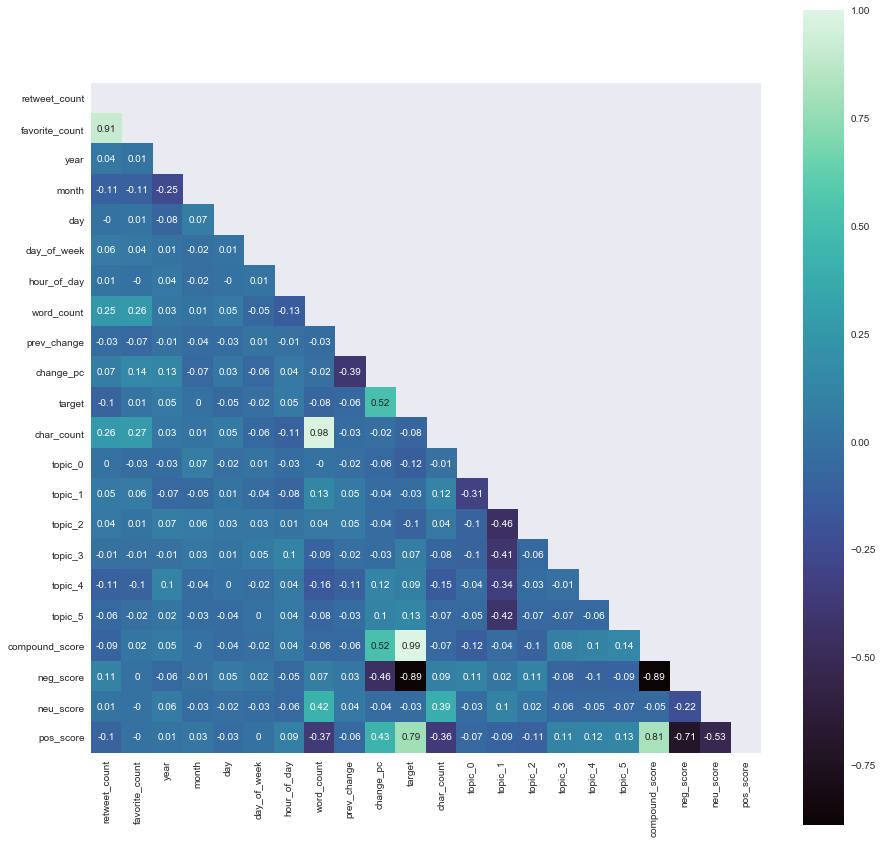

In [113]:
fig ,ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(tweets_trade.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(round(tweets_trade.corr(), 2), annot=True, cmap='mako', mask=mask, square=True, ax=ax)

In [114]:
tweets_trade.to_csv('../datasets/final_tweets.csv', index=False)